A look at the data
The data come in readily separated files by attribute scores (e.g., Strength) and positional scores (i.e., how good they are as a striker), as well as other information like country of origin and which club they belong to. For our purposes, we are only concerned with their wage attributes, and positional scores. There is an ID variable by which to merge them easily.

In [2]:
import pandas as pd
player_wage = pd.read_csv('PlayerPersonalData.csv', usecols = ['ID', 'Wage'])
player_attributes = pd.read_csv('PlayerAttributeData.csv', index_col = 0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
player_wage.head()

,ID,Wage
0,20801,€565K
1,158023,€565K
2,190871,€280K
3,176580,€510K
4,167495,€230K


In [4]:
player_attributes.head()

,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,Heading accuracy,ID,Interceptions,Jumping,Long passing,Long shots,Marking,Penalties,Positioning,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys
0,89,63,89,63,93,95,85,81,91,94,76,7,11,15,14,11,88,20801,29,95,77,92,22,85,95,96,83,94,23,91,92,31,80,85,88
1,92,48,90,95,95,96,77,89,97,95,90,6,11,15,14,8,71,158023,22,68,87,88,13,74,93,95,88,85,26,87,73,28,59,90,85
2,94,56,96,82,95,92,75,81,96,89,84,9,9,15,15,11,62,190871,36,61,75,77,21,81,90,88,81,80,33,90,78,24,53,80,83
3,88,78,86,60,91,83,77,86,86,94,84,27,25,31,33,37,77,176580,41,69,64,86,30,85,92,93,83,87,38,77,89,45,80,84,88
4,58,29,52,35,48,70,15,14,30,13,11,91,90,95,91,89,25,167495,30,78,59,16,10,47,12,85,55,25,11,61,44,10,83,70,11


In [7]:
player_position = pd.read_csv('PlayerPlayingPositionData.csv', index_col=0)
player_position.head()

,CAM,CB,CDM,CF,CM,ID,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,Preferred Positions,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,89.0,53.0,62.0,91.0,82.0,20801,89.0,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,ST LW,89.0,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,92.0,45.0,59.0,92.0,84.0,158023,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,RW,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,88.0,46.0,59.0,88.0,79.0,190871,88.0,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,LW,88.0,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,87.0,58.0,65.0,88.0,80.0,176580,87.0,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,ST,87.0,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,NaN,NaN,NaN,NaN,NaN,167495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
full_data = player_wage.merge(player_attributes, how='outer',left_on='ID',right_on='ID').merge(player_attributes, how='outer',left_on='ID',right_on='ID')
full_data.head()

,ID,Wage,Acceleration_x,Aggression_x,Agility_x,Balance_x,Ball control_x,Composure_x,Crossing_x,Curve_x,Dribbling_x,Finishing_x,Free kick accuracy_x,GK diving_x,GK handling_x,GK kicking_x,GK positioning_x,GK reflexes_x,Heading accuracy_x,Interceptions_x,Jumping_x,Long passing_x,Long shots_x,Marking_x,Penalties_x,Positioning_x,Reactions_x,Short passing_x,Shot power_x,Sliding tackle_x,Sprint speed_x,Stamina_x,Standing tackle_x,Strength_x,Vision_x,Volleys_x,Acceleration_y,Aggression_y,Agility_y,Balance_y,Ball control_y,Composure_y,Crossing_y,Curve_y,Dribbling_y,Finishing_y,Free kick accuracy_y,GK diving_y,GK handling_y,GK kicking_y,GK positioning_y,GK reflexes_y,Heading accuracy_y,Interceptions_y,Jumping_y,Long passing_y,Long shots_y,Marking_y,Penalties_y,Positioning_y,Reactions_y,Short passing_y,Shot power_y,Sliding tackle_y,Sprint speed_y,Stamina_y,Standing tackle_y,Strength_y,Vision_y,Volleys_y
0,20801,€565K,89,63,89,63,93,95,85,81,91,94,76,7,11,15,14,11,88,29,95,77,92,22,85,95,96,83,94,23,91,92,31,80,85,88,89,63,89,63,93,95,85,81,91,94,76,7,11,15,14,11,88,29,95,77,92,22,85,95,96,83,94,23,91,92,31,80,85,88
1,158023,€565K,92,48,90,95,95,96,77,89,97,95,90,6,11,15,14,8,71,22,68,87,88,13,74,93,95,88,85,26,87,73,28,59,90,85,92,48,90,95,95,96,77,89,97,95,90,6,11,15,14,8,71,22,68,87,88,13,74,93,95,88,85,26,87,73,28,59,90,85
2,190871,€280K,94,56,96,82,95,92,75,81,96,89,84,9,9,15,15,11,62,36,61,75,77,21,81,90,88,81,80,33,90,78,24,53,80,83,94,56,96,82,95,92,75,81,96,89,84,9,9,15,15,11,62,36,61,75,77,21,81,90,88,81,80,33,90,78,24,53,80,83
3,176580,€510K,88,78,86,60,91,83,77,86,86,94,84,27,25,31,33,37,77,41,69,64,86,30,85,92,93,83,87,38,77,89,45,80,84,88,88,78,86,60,91,83,77,86,86,94,84,27,25,31,33,37,77,41,69,64,86,30,85,92,93,83,87,38,77,89,45,80,84,88
4,167495,€230K,58,29,52,35,48,70,15,14,30,13,11,91,90,95,91,89,25,30,78,59,16,10,47,12,85,55,25,11,61,44,10,83,70,11,58,29,52,35,48,70,15,14,30,13,11,91,90,95,91,89,25,30,78,59,16,10,47,12,85,55,25,11,61,44,10,83,70,11


In [10]:
full_data.describe()

,ID
count,18293.000000
mean,207683.540644
std,32036.717351
min,16.000000
25%,193064.000000
50%,213797.000000
75%,231206.000000
max,241219.000000


In [12]:
full_data.shape

(18293, 70)

We notice there are some symbols that have to be removed as well as some missing values that must be dealt with. Additionally, upon inspection we find some scores above the maximum of 100.

Cleaning the data
Here we perform some simple cleaning tasks in order to further explore the data. First, we remove rows with empty values.

In [17]:
full_data.isnull().any(axis=1).sum() # number of rows with empty values

0

In [0]:
full_data = full_data.dropna(axis=0)

Second, we extract the numbers from out wage variable. We find they are all in thousands of euros, so there will not need to be any unit conversions.

In [21]:
full_data.Wage.str.extract('([A-Za-z])')[0].unique()

array(['K', nan], dtype=object)

In [0]:
full_data.Wage = full_data.Wage.str.extract('(\d+)')

In [0]:
full_data = full_data.drop(columns=['ID'])

Now, we extract only the leading numbers from each score as some are proceeded by +/-, possibly indicating a change in score since the last assessment. Then, we preserve only scores no greater than 100 as per the indicated cap.

In [30]:
full_data = full_data.apply(lambda x : x.replace('(\+|\-\d+$)', '' , regex = True), axis=1).apply(lambda x: x.astype(float))
full_data = full_data[(full_data.drop(columns='Wage') <= 100).all(axis=1)]
full_data.shape

(17800, 69)

Exploring with a few visuals
As we are intending to find relationships between skills and wage, we can use a few charts to get an idea of how one effects the other. We will plot a few variables to get a rough idea.

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

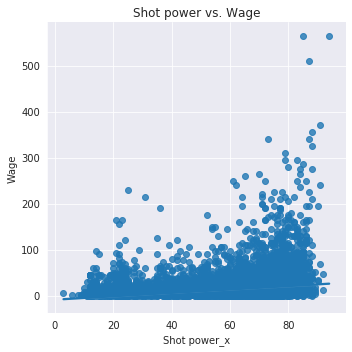

In [35]:
plot_st = sns.lmplot('Shot power_x', 'Wage', data=full_data)
plt.title('Shot power vs. Wage')
plt.tight_layout()
plt.show()

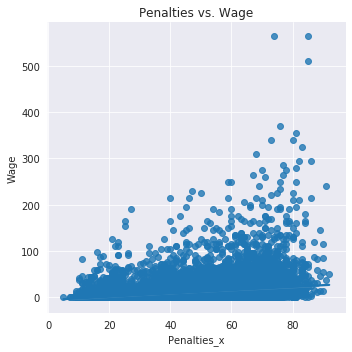

In [36]:
plot_pt = sns.lmplot('Penalties_x', 'Wage', data=full_data)
plt.title('Penalties vs. Wage')
plt.tight_layout()
plt.show()

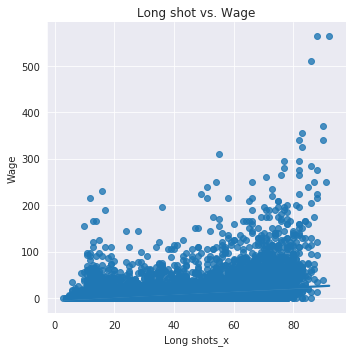

In [37]:
plot_ls = sns.lmplot('Long shots_x', 'Wage', data=full_data)
plt.title('Long shot vs. Wage')
plt.tight_layout()
plt.show()

There appears to be a slight positive correlation between each skill and wage, but nothing very convincing.

**Trying linear regression**

In [0]:
from sklearn.linear_model import LinearRegression

In [44]:
model_linear = LinearRegression()
predictors = full_data.drop(columns='Wage')
response = full_data.Wage
model_linear.fit(predictors, response)

model_linear.score(predictors, response)

0.3084040776176794

Reinforcing what we saw in our graphs, we find a small R-squared value–less than 32% of the variance in Wage is explained by the variance in the skill and positional scores. Linear regression methods won’t be very useful. Given the high-dimensionality of the data, we won’t pursue polynomial regression methods, either, due to the computational cost associated with them. We could pursue more sophiscated methods like random forest or gradient boosting regression, but they will be saved for another data set.

In [45]:
model_linear.predict(predictors)

array([ 63.11079013,  61.89109109,  52.86676746, ...,  -9.46811901,
       -12.52470211, -26.18483348])

**Classification based on the mean wage**

Instead of trying to predict wage accurately, perhaps we would have an easier time classifying whether or not a player’s income falls above or below the mean. We will compare 5 classifiers–k-nearest neighbors, logistic regression, linear discriminant analysis, quadratic discriminant analysis, and random forest–via cross-validation. We will then choose the best performing model to predict on a new test set.

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.ensemble import RandomForestClassifier as RF 
from sklearn.neighbors import KNeighborsClassifier as KNN 
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(333)

We create the new response variable and assemble our training and testing sets from the data using a 70/30 split:

In [51]:
response = [0 if x < np.mean(full_data.Wage) else 1 for x in full_data.Wage]
sum(response)/len(response)

0.26348314606741574

In [0]:
train_predictors, test_predictors, train_response, test_response = train_test_split(full_data.drop(columns='Wage'), response, train_size = 0.7)

We see that less than 27% of players make more than the mean wage.

Now, we fit each model, 10-fold cross-validate them on the training data, and compare their performance with a heatmap. The metrics we will use are precision and recall, as the proportion of “positive” cases–wages above the mean–is much smaller than that of “negative” cases.

In [58]:
# logit
model_lr = LR(solver='liblinear', max_iter = 10000)
cross_val_lr_pred = cross_val_predict(model_lr, train_predictors, train_response, cv=10)
rep_lr = classification_report(train_response, cross_val_lr_pred, output_dict=True)

# lda
model_lda = LDA()
cross_val_lda_pred = cross_val_predict(model_lda, train_predictors, train_response, cv = 10)
rep_lda = classification_report(train_response, cross_val_lda_pred, output_dict=True)

# qda
model_qda = QDA()
cross_val_qda_pred = cross_val_predict(model_qda, train_predictors, train_response, cv = 10)
rep_qda = classification_report(train_response, cross_val_qda_pred, output_dict=True)

# knn
model_knn = KNN(n_neighbors = 13)
cross_val_knn_pred = cross_val_predict(model_knn, train_predictors, train_response, cv = 10)
rep_knn = classification_report(train_response, cross_val_knn_pred, output_dict=True)

# random forest
model_rf = RF(n_estimators = 500)
cross_val_rf_pred = cross_val_predict(model_rf, train_predictors, train_response, cv = 10)
rep_rf = classification_report(train_response, cross_val_rf_pred, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminan

Text(0.5, 1, 'Model performance during cross-validation')

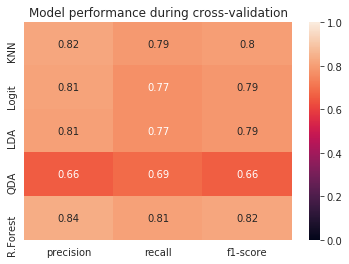

In [60]:
reports = [x['macro avg'] for x in [rep_knn, rep_lr, rep_lda, rep_qda, rep_rf]]
models = ['KNN', 'Logit', 'LDA', 'QDA', 'R.Forest']
reports_df = pd.DataFrame.from_dict(dict(zip(models, reports)), orient='index').drop(columns = 'support')

sns.heatmap(reports_df, vmin=0, vmax=1, annot=True).set_title('Model performance during cross-validation')

Note: warnings for collinearity were suppressed during LDA and QDA cross-validation. Intuitively, it makes sense that athletic skills may be collinear.

We see that random forest classification produced the best f1-score, and also performed the best in both precision and recall. This is the model we will select for predicting on our test set. The disparate performance between LDA and QDA suggests that the decision boundary is more linear than quadratic–sensible, as we divided the class at the mean.

**Evaluating our model on the test data**

In [61]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

model_rf = RF(n_estimators=500)
model_rf.fit(train_predictors, train_response)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
probs_rf = model_rf.predict_proba(test_predictors)[:,1]
precision_rf, recall_rf, threshold_rf = precision_recall_curve(test_response, probs_rf)
pr_rf = pd.DataFrame.from_dict({'recall':recall_rf, 'precision':precision_rf}, orient='columns')

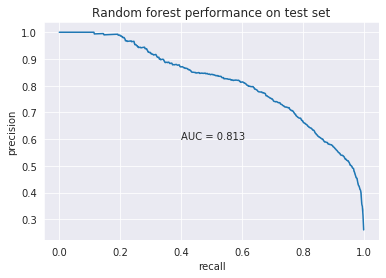

In [64]:
import matplotlib.pyplot as plt
auc_rf = auc(recall_rf, precision_rf)
line_rf = sns.lineplot('recall', 'precision', data = pr_rf, legend=False).set_title('Random forest performance on test set')
plt.text(x=0.4, y=0.6, s=str('AUC = %.3f' % auc_rf))
plt.show()

We see that our model does alright with an AUC of ~0.817, and is certainly better than guessing. However, there is still plenty of room for improvement.

**Summary**

There does appear to be a positive relationship between a players skill and how much they earn, though it doesn’t seem to be linear in nature. Even a simple classification of above or below the mean wage using only skills was not absolutely conclusive given a random forest precision-recall AUC of just under 0.82. This suggests that they contribute to FIFA players’ compensation but that there are other factors at play. Perhaps the best way to proceed would be to include some of the other features from the data set as necessary, or even pursing different regression or classification models.